In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from scipy import stats
import itertools
from pprint import pprint
# from lazypredict.Supervised import LazyRegressor

/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pearson correlation R and p-val are:  0.39242 , 6.958756814991382e-52


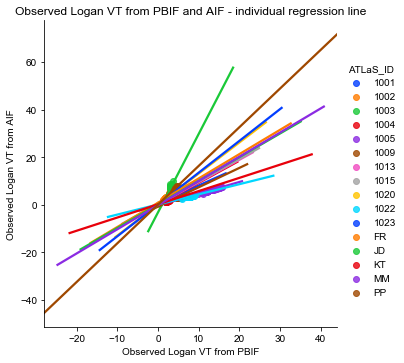

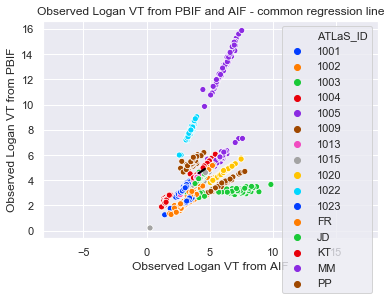

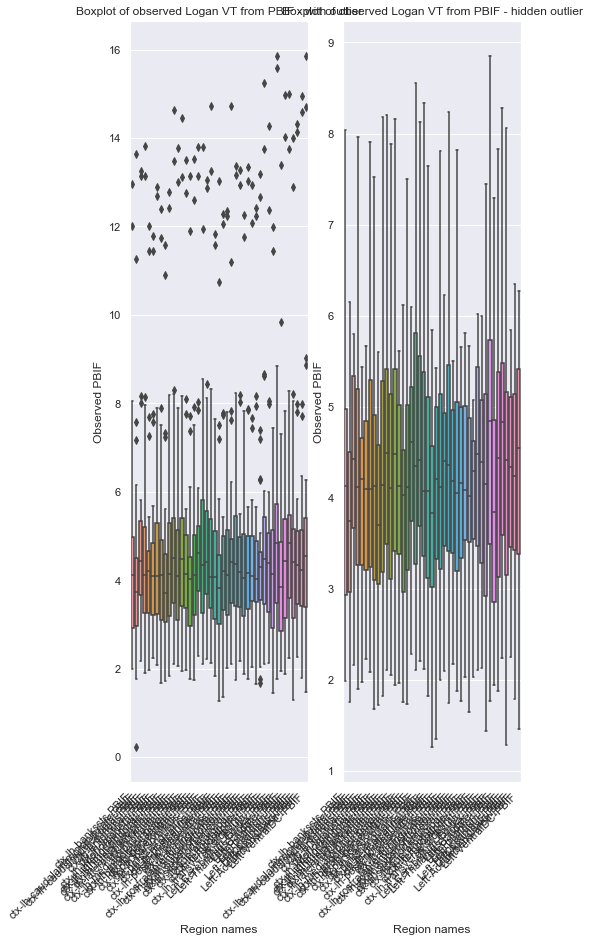

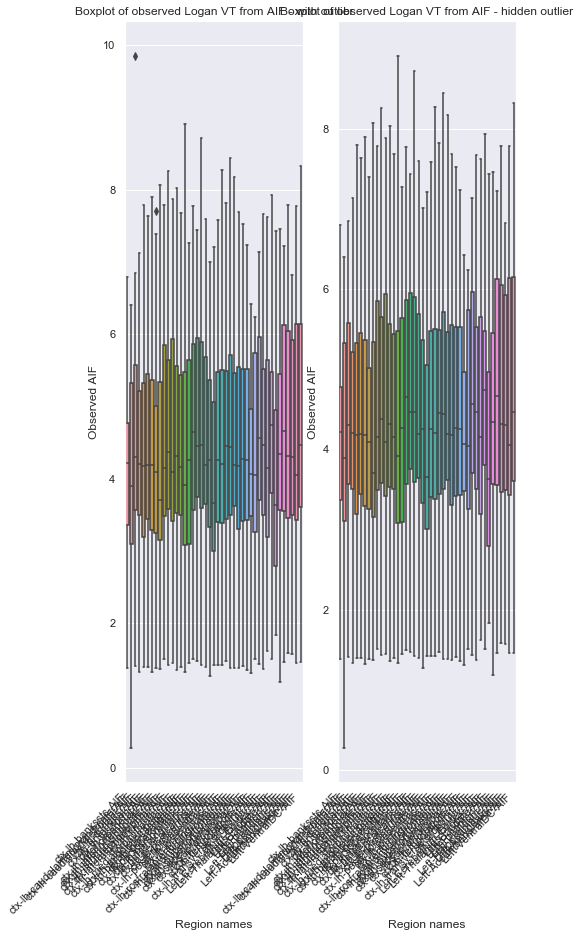

<Figure size 504x1008 with 0 Axes>

In [2]:
input_file = "~/Downloads/ATLAS_PD_MS_ML_Compiled_Features_excelForFormat.csv"
# https://stackoverflow.com/questions/49371931/unicodeerror-utf-16-stream-does-not-start-with-bom
df = pd.read_csv(input_file, encoding='utf-8')
# df = pd.read_csv(input_file, encoding='utf-16')
# Drop right-hemisphere labels in middle (11th)
# df = df.drop(11)  # Dropping row with right hemisphere labels
# df = df[df["ctx-lh-bankssts-PBIF"].str.contains("ctx-rh-bankssts-PBIF") == False]  # Dropping row with right hemisphere labels
df = df.dropna(subset=['ATLaS_ID'])  # Dropping row with right hemisphere labels
df['ATLaS_ID'] = df['ATLaS_ID'].astype(str)
df['H&Y Stage'] = df['H&Y Stage'].astype('Int32')
df.loc[:, ["Sex", "Genotype"]] = df.loc[:, ["Sex", "Genotype"]].astype("int")  # df.iloc[:, [0, 2, 3, 7]] = df.iloc[:, [0, 2, 3, 7]].astype("int")
# df.loc[:, np.r_["Age", "NET dose (mCi)":"AUC", "ctx-lh-bankssts-PBIF":len(df.columns)]] = df.loc[:, np.r_["Age", "NET dose (mCi)":"AUC", "ctx-lh-bankssts-PBIF":len(df.columns)]].astype('float')   # This does not work as np._ workswith .iloc but not .loc
df.iloc[:, np.r_[1, 4:6, 8:len(df.columns)]] = df.iloc[:, np.r_[1, 4:6, 8:len(df.columns)]].astype('float')
# Scale age, weight, and AUC by a constant. Using this method as we want to leave AIF and PBIF untouched
df.loc[:, 'Age'] = df.loc[:, 'Age']/10
df.loc[:, 'Weight (Kgs)'] = df.loc[:, 'Weight (Kgs)']/10
df.loc[:, 'AUC'] = df.loc[:, 'AUC']/1000
df = df.drop("H&Y Stage", 1)  # Dropping column "H&Y Stage" from the dataframe.
df = df.drop("AUC", 1)  # Dropping column "AUC" from the dataframe
X_end_index = df.columns.get_loc("Left-VentralDC-PBIF") + 1
X = df.loc[:, "Age":"Left-VentralDC-PBIF"]  # X = df.iloc[:, 1:X_end_index]  # X = df.iloc[:, 1:51]
y = df.loc[:, "ctx-lh-bankssts-AIF":]  # y = df.iloc[:, X_end_index:]  # y = df.iloc[:, 51:]


# Plot original VT from PBIF and VT from AIF
PBIF_start_index = df.columns.get_loc("ctx-lh-bankssts-PBIF")
# df.iloc[:, np.r_[1:3, 6:len(df.columns)]]
# df_plot = df.iloc[:, 8:51].copy()
# df_plot = df.loc[:, np.r_[0, "ctx-lh-bankssts-PBIF":"Left-VentralDC-PBIF"]].copy()  # This does not work, as np.r_ works with .iloc but not with .loc
df_plot = df.iloc[:, np.r_[0, PBIF_start_index:X_end_index]].copy()  # df_plot = df.iloc[:, np.r_[0, 8:51]].copy()
# df_plot_long = pd.melt(df_plot.astype(float), id_vars='ATLaS_ID')
df_plot_long = pd.melt(df_plot, id_vars='ATLaS_ID')
df_plot_long.columns = ['ATLaS_ID', 'regions_PBIF', 'VT_PBIF']
df_AIF = y.copy()
df_AIF_long = pd.melt(df_AIF.astype(float))
df_AIF_long.columns = ['regions_AIF', 'VT_AIF']
df_plot_long["regions_AIF"] = df_AIF_long["regions_AIF"]
df_plot_long["VT_AIF"] = df_AIF_long["VT_AIF"].values
df_plot_long["ATLaS_ID"] = df_plot_long["ATLaS_ID"].astype(str)
ATLaS_ID = df_plot_long['ATLaS_ID'].to_numpy()

# plot original data
sns.lmplot(data=df_plot_long, x='VT_PBIF', y='VT_AIF', hue="ATLaS_ID", palette="bright", ci=None)
plt.title('Observed Logan VT from PBIF and AIF - individual regression line')
plt.xlabel('Observed Logan VT from PBIF')
plt.ylabel('Observed Logan VT from AIF')
plt.savefig("Original-lineplot.png")

fig = plt.figure()

sns.set(rc={"figure.figsize":(7, 14)})
sns.regplot(data=df_plot_long, x='VT_AIF', y='VT_PBIF', line_kws={"color": "black"}, scatter=False)
sns.scatterplot(data=df_plot_long, x="VT_AIF", y="VT_PBIF", hue="ATLaS_ID", palette="bright", legend="full")
plt.title('Observed Logan VT from PBIF and AIF - common regression line')
plt.ylabel('Observed Logan VT from PBIF')
plt.xlabel('Observed Logan VT from AIF')
plt.axis('equal')
slope_o, intercept_o, r_value_o, p_value_o, std_err_o = stats.linregress(df_plot_long['VT_AIF'], df_plot_long['VT_PBIF'])
print('Pearson correlation R and p-val are: ', r_value_o.round(5), ',', p_value_o)
plt.savefig("Original-Scatters.png")

# View the outliers
fig = plt.figure()
plt.subplot(121)
# X_PBIF_boxplot = sns.boxplot(x="Region names", y="Observed PBIF", data=pd.melt(X.iloc[:, 7:51].astype(float), var_name='Region names', value_name='Observed PBIF'))
X_PBIF_boxplot = sns.boxplot(x="Region names", y="Observed PBIF", data=pd.melt(X.loc[:, "ctx-lh-bankssts-PBIF":"Left-VentralDC-PBIF"].astype(float), var_name='Region names', value_name='Observed PBIF'))
X_PBIF_boxplot.set_xticklabels(X_PBIF_boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Boxplot of observed Logan VT from PBIF - with outlier')
plt.subplot(122)
# X_PBIF_boxplot = sns.boxplot(x="Region names", y="Observed PBIF", data=pd.melt(X.iloc[:, 7:51].astype(float), var_name='Region names', value_name='Observed PBIF'), showfliers = False)
X_PBIF_boxplot = sns.boxplot(x="Region names", y="Observed PBIF", data=pd.melt(X.loc[:, "ctx-lh-bankssts-PBIF":"Left-VentralDC-PBIF"].astype(float), var_name='Region names', value_name='Observed PBIF'), showfliers = False)
X_PBIF_boxplot.set_xticklabels(X_PBIF_boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Boxplot of observed Logan VT from PBIF - hidden outlier')

fig = plt.figure()
plt.subplot(121)
y_boxplot = sns.boxplot(x="Region names", y="Observed AIF", data=pd.melt(y.astype(float), var_name='Region names', value_name='Observed AIF'))
y_boxplot.set_xticklabels(y_boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Boxplot of observed Logan VT from AIF - with outlier')
plt.subplot(122)
y_boxplot = sns.boxplot(x="Region names", y="Observed AIF", data=pd.melt(y.astype(float), var_name='Region names', value_name='Observed AIF'), showfliers = False)
y_boxplot.set_xticklabels(y_boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Boxplot of observed Logan VT from AIF - hidden outlier')
# plt.show()

Q1_X = X.loc[:, "ctx-lh-bankssts-PBIF":].quantile(0.25)  # Q1_X = X.iloc[:, 7:].quantile(0.25)
Q3_X = X.loc[:, "ctx-lh-bankssts-PBIF":].quantile(0.75)  # Q3_X = X.iloc[:, 7:].quantile(0.75)
IQR_X = Q3_X - Q1_X
# if filtering both upper and lower bounds
# filter = (X >= Q1 - 1.5 * IQR) & (X <= Q3 + 1.5 *IQR)
# if filtering only upper bound
filter_X = (X.loc[:, "ctx-lh-bankssts-PBIF":] <= Q3_X + 1.5 * IQR_X)  # filter_X = (X.iloc[:, 7:] <= Q3_X + 1.5 * IQR_X)
X.loc[:, "ctx-lh-bankssts-PBIF":] = X.loc[:, "ctx-lh-bankssts-PBIF":].where(filter_X, other=np.nan)  # X.iloc[:, 7:] = X.iloc[:, 7:].where(filter_X, other=np.nan)
# Replace the outliers with NAN. In this case we replace any VT values above upper bound with NaN. Once we replace outliers with NaN, we replace those with median
X_noOutlier = X.fillna(X.median())

# what does this even mean?
Q1_y = y.quantile(0.25)
Q3_y = y.quantile(0.75)
IQR_y = Q3_y - Q1_y
filter_y = (y <= Q3_y + 1.5 * IQR_y)
y = y.where(filter_y, other=np.nan)
y_noOutlier = y.fillna(y.median())

# define cross-validation method to use


fig = plt.figure()
# set palette
palette = itertools.cycle(sns.color_palette())

In [3]:
y_noOutlier

,ctx-lh-bankssts-AIF,ctx-lh-caudalanteriorcingulate-AIF,ctx-lh-caudalmiddlefrontal-AIF,ctx-lh-cuneus-AIF,ctx-lh-entorhinal-AIF,ctx-lh-fusiform-AIF,ctx-lh-inferiorparietal-AIF,ctx-lh-inferiortemporal-AIF,ctx-lh-isthmuscingulate-AIF,ctx-lh-lateraloccipital-AIF,...,ctx-lh-insula-AIF,Left-Cerebellum-Cortex-AIF,Left-Thalamus-Proper-AIF,Left-Caudate-AIF,Left-Putamen-AIF,Left-Pallidum-AIF,Left-Hippocampus-AIF,Left-Amygdala-AIF,Left-Accumbens-area-AIF,Left-VentralDC-AIF
0,3.125203,1.873116,3.026488,3.066844,3.117090,2.923615,2.975958,3.122835,2.604903,2.839497,...,3.209057,2.587755,3.670306,2.812893,3.187369,3.422196,2.850343,3.241260,3.100149,2.966440
1,4.177566,4.001726,4.797934,4.164397,4.404920,4.265981,4.123583,4.351055,3.672082,4.109379,...,4.594383,4.345024,5.209784,3.596146,4.612134,5.019328,4.869401,4.947333,5.024508,4.938094
2,6.798339,5.996654,4.172483,7.130261,6.909646,7.484297,7.894639,4.012902,6.468731,7.783759,...,7.495862,7.624260,7.926448,4.152393,7.126104,6.356390,7.245702,6.820607,6.396845,8.321740
3,4.504249,3.067001,4.623479,4.423945,3.999827,4.201309,4.800641,4.350727,3.406117,4.762298,...,4.318038,4.310324,5.148324,4.081895,4.706808,4.981016,4.260664,4.490494,4.552298,4.457660
4,6.187557,6.397762,6.246417,6.091463,5.645087,5.452820,6.030841,5.903451,5.548808,5.810986,...,5.863077,5.538975,7.541340,4.591923,6.558390,6.503927,6.644773,6.771543,6.782976,7.540600
5,3.251689,3.640094,3.488588,3.808203,3.165270,3.782511,3.503088,3.300699,3.734807,3.694768,...,3.626466,3.841946,3.807341,2.908689,3.878036,3.476682,3.536618,3.554233,3.246256,3.748539
6,3.937230,3.113986,4.146916,3.596803,3.956943,3.778832,3.820019,3.876286,3.280671,3.552171,...,4.066538,3.433611,4.306378,2.673897,3.945309,4.160017,3.795996,4.146565,3.736848,4.180387
7,4.247210,0.279044,4.653723,4.311167,4.511180,4.116990,4.243420,4.198694,2.485102,4.224036,...,4.610748,3.928322,5.112683,3.682667,4.965569,4.965923,4.469742,4.320746,4.235368,4.656267
8,6.226713,5.323264,6.406424,5.894871,6.063891,5.986334,6.012579,6.134036,5.308826,5.998421,...,6.241297,6.101625,7.492272,5.233588,6.376922,6.718285,6.087326,6.414141,6.469192,7.033518
9,3.476571,3.206528,3.656379,3.491500,3.206734,3.476944,3.397419,3.320784,3.167962,3.480909,...,3.517425,3.215705,3.846272,2.736822,3.438013,3.597879,3.553311,3.427199,3.354274,3.978442


In [20]:
# cv = LeaveOneOut()

# y_true, y_pred = list(), list()
# mae_errs = list()
# 

# for train_index, test_index in cv.split(X_noOutlier):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X_noOutlier.iloc[train_index, :], X_noOutlier.iloc[test_index, :]
#     y_train, y_test = y_noOutlier.iloc[train_index], y_noOutlier.iloc[test_index]

#     # Fit all regression models
#     reg = LazyRegressor(predictions=True, random_state=0)
#     models, predictions = reg.fit(X_train, X_test.iloc, y_train.iloc[:, 0], y_test.iloc[:, 0])
#     models

# print('debug')

In [4]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    # print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Average Error: {:0.4f} degrees.'.format(errors.mean()))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

### Random Forest

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [0]
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Model Performance
Average Error: 1.0275 degrees.
Accuracy = 63.87%.
Mean Absolute Error of base model: 1.0274918631155225
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 31 folds for each of 100 candidates, total

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 3100 out of 3100 | elapsed: 13.6min finished


Model Performance
Average Error: 0.7177 degrees.
Accuracy = 74.41%.
Improvement of the model with random search cv from the base model 16.49%.


ValueError: shapes (100,2) and (44,43) not aligned: 2 (dim 1) != 44 (dim 0)

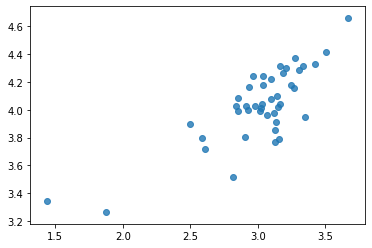

In [23]:
y_true_base, y_pred_base = list(), list()
mae_errs_base = list()

y_true_tunedModel, y_pred_tunedModel = list(), list()
mae_errs_tunedModel = list()

fig = plt.figure()
# set palette
palette = itertools.cycle(sns.color_palette())

for train_index, test_index in cv.split(X_noOutlier):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_noOutlier.iloc[train_index, :], X_noOutlier.iloc[test_index, :]
    y_train, y_test = y_noOutlier.iloc[train_index], y_noOutlier.iloc[test_index]

    ##### Parameter tuning using random search cv #####
    # Examine the Default Random Forest to Determine Parameters. We will use these parameters as a starting point.
    # First create the base model to tune
    rf = RandomForestRegressor(random_state=0)

    # Look at parameters used by our current forest
    print('Parameters currently in use:\n')
    pprint(rf.get_params())

    # Fit the regressor with x and y data
    rf.fit(X_train, y_train)  # use this if age, weight, and auc are scaled by a constant
    base_accuracy = evaluate(rf, X_test.to_numpy(), y_test.to_numpy())

    # For other metrics, we need the predictions of the model
    # Predicting a new result
    yhat = rf.predict(X_test)

    # store
    y_true_base.append(y_test.to_numpy())
    y_pred_base.append(yhat)

    print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
    mae_errs_base.append(mean_absolute_error(y_test, yhat))

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    pprint(random_grid)


    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                                   cv=cv,
                                   scoring='neg_mean_absolute_error', verbose=2,
                                   random_state=0, n_jobs=-1, return_train_score=True)
    # Fit the random search model
    model = rf_random.fit(X_train, y_train)

    best_random = rf_random.best_estimator_
    random_accuracy = evaluate(best_random, X_test.to_numpy(), y_test.to_numpy())
    print('Improvement of the model with random search cv from the base model {:0.2f}%.'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

    # color
    c = next(palette)
    # sns.regplot(x=y_test, y=yhat, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    sns.regplot(x=y_test, y=yhat, color=c, ci=None)
    fig.legend(df['ATLaS_ID'].unique())
    plt.title('Multi output Random Forest Regression - individual regression lines')
    plt.xlabel('Observed Logan VT (from AIF)')
    plt.ylabel('Predicted Logan VT')

fig = plt.figure()
sns.regplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), scatter=False)
sns.scatterplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
plt.title('Multi output Random Forest Regression - common regression lines')
plt.xlabel('Observed Logan VT (from AIF)')
plt.ylabel('Predicted Logan VT')
plt.show()
print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

print('debug')

In [24]:
best_random

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400,
                      random_state=0)

#### Best RF model

In [25]:
evaluate(best_random, X_test.to_numpy(), y_test.to_numpy())

Model Performance
Average Error: 0.7177 degrees.
Accuracy = 74.41%.


74.40893433357724

### SVR

In [125]:
cv = LeaveOneOut()

y_true, y_pred = list(), list()
mae_errs = list()

fig = plt.figure()
# set palette
palette = itertools.cycle(sns.color_palette())

for train_index, test_index in cv.split(X_noOutlier):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_noOutlier.iloc[train_index, :], X_noOutlier.iloc[test_index, :]
    y_train, y_test = y_noOutlier.iloc[train_index], y_noOutlier.iloc[test_index]

    svr = SVR()

    # Building the SVR single-output regressor.
    model_svr = MultiOutputRegressor(svr)

    # Look at parameters used by our current forest
    print('Parameters currently in use:\n')
    pprint(model_svr.estimator.get_params())

    # Base model evaluation: Fit the regressor with x and y data
    model_svr.fit(X_train, y_train)  # use this if age, weight, and auc are scaled by a constant
    base_model_accuracy = evaluate(model_svr, X_test.to_numpy(), y_test.to_numpy())

    # For other metrics, we need the predictions of the model
    # Predicting a new result
    yhat = model_svr.predict(X_test)

    # store
    y_true.append(y_test.to_numpy())
    y_pred.append(yhat)

    print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
    mae_errs.append(mean_absolute_error(y_test, yhat))

    # Random search hyper-parameter tuning
    hyperparameters_random_grid = {
        'estimator__kernel': ("rbf", "linear"),
        'estimator__C': [0.01,0.1,1,10,20,30,40,50,60,70,80,90,100],
        'estimator__epsilon': [float(x) for x in np.linspace(start=0.001, stop=1, num=5)]
    }
    pprint(hyperparameters_random_grid)

    randomized_search_svr = RandomizedSearchCV(estimator=model_svr, param_distributions=hyperparameters_random_grid,
                                   n_iter=100, cv=cv,
                                   scoring='neg_mean_absolute_error', verbose=2,
                                   random_state=0, n_jobs=-1, return_train_score=True)

    # Fit the random search model
    hyperparameters_tuning = randomized_search_svr.fit(X_train, y_train)
    print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

    tuned_model = hyperparameters_tuning.best_estimator_
    print(tuned_model.predict(X_test))

    tuned_model_accuracy = evaluate(tuned_model, X_test.to_numpy(), y_test.to_numpy())
    print('Improvement of the model with random search cv from the base model {:0.2f}%.'.format(100 * (tuned_model_accuracy - base_model_accuracy) / base_model_accuracy))

    # color
    c = next(palette)
    # sns.regplot(x=y_test, y=yhat, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    sns.regplot(x=np.array(y_test).reshape(-1), y=yhat.reshape(-1), color=c, ci=None)

    fig.legend(df['ATLaS_ID'].unique())
    plt.title('Multi output Random Forest Regressiong - individual regression lines')
    plt.xlabel('Observed Logan VT (from AIF)')
    plt.ylabel('Predicted Logan VT')

fig = plt.figure()
sns.regplot(x=np.vstack(y_true).flatten(), y=np.vstack(y_pred).flatten(), scatter=False)
sns.scatterplot(x=np.vstack(y_true).flatten(), y=np.vstack(y_pred).flatten(), hue=ATLaS_ID, palette="bright",
                legend="full")
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true).flatten(),
                                                                         np.vstack(y_pred).flatten())
plt.title('Multi output Random Forest Regression - common regression lines')
plt.xlabel('Observed Logan VT (from AIF)')
plt.ylabel('Predicted Logan VT')
plt.show()
print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [0]
Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


NameError: name 'evaluate' is not defined

<Figure size 504x1008 with 0 Axes>

In [1]:
tuned_model_accuracy

NameError: name 'tuned_model_accuracy' is not defined

In [32]:
evaluate(tuned_model, X_test.to_numpy(), y_test.to_numpy())

Model Performance
Average Error: 0.3699 degrees.
Accuracy = 93.75%.


93.75062923844627

In [135]:
(predict-truth)>std

array([False, False, False, ..., False, False, False])

In [134]:
np.sum((predict-truth)>std)

41

In [131]:
std = np.std(truth)

In [124]:
y_test

,ctx-lh-bankssts-AIF,ctx-lh-caudalanteriorcingulate-AIF,ctx-lh-caudalmiddlefrontal-AIF,ctx-lh-cuneus-AIF,ctx-lh-entorhinal-AIF,ctx-lh-fusiform-AIF,ctx-lh-inferiorparietal-AIF,ctx-lh-inferiortemporal-AIF,ctx-lh-isthmuscingulate-AIF,ctx-lh-lateraloccipital-AIF,...,ctx-lh-insula-AIF,Left-Cerebellum-Cortex-AIF,Left-Thalamus-Proper-AIF,Left-Caudate-AIF,Left-Putamen-AIF,Left-Pallidum-AIF,Left-Hippocampus-AIF,Left-Amygdala-AIF,Left-Accumbens-area-AIF,Left-VentralDC-AIF
32,4.54,5.63,6.25,5.17,5.40,5.87,5.48,4.87,5.65,5.96,...,5.93,6.74,5.68,7.43,5.10,6.24,7.79,6.28,6.25,5.96


### Other Multi-Output models

In [5]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

In [6]:
X_test

NameError: name 'X_test' is not defined

In [7]:
fig = plt.figure()
# sns.set(rc={"figure.figsize":(7, 7)})
sns.regplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), scatter=False)
sns.scatterplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
plt.title('Multi output GBR - common regression lines')
plt.xlabel('Observed Logan VT (from AIF)')
plt.ylabel('Predicted Logan VT')
plt.axis('equal')
plt.savefig("GBR-Scatter.png")
print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

NameError: name 'y_true_base' is not defined

<Figure size 504x1008 with 0 Axes>

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [0]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.1174 degrees.
Accuracy = 95.27%.
Mean Absolute Error of base model: 0.1174428127599707
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [1]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2835 degrees.
Accuracy = 93.48%.
Mean Absolute Error of base model: 0.28345024736271035
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [2]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 1.8882 degrees.
Accuracy = 73.42%.
Mean Absolute Error of base model: 1.8881627525646374
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [3]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.3363 degrees.
Accuracy = 91.88%.
Mean Absolute Error of base model: 0.3362597797236413
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [4]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.5002 degrees.
Accuracy = 91.91%.
Mean Absolute Error of base model: 0.5002294215969538


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [5]
Model Performance
Average Error: 0.5766 degrees.
Accuracy = 83.42%.
Mean Absolute Error of base model: 0.5766217846971714
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [6]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.5514 degrees.
Accuracy = 84.84%.
Mean Absolute Error of base model: 0.551384627299116
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [7]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.5666 degrees.
Accuracy = 66.74%.
Mean Absolute Error of base model: 0.566626411123888
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [8]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.4976 degrees.
Accuracy = 91.85%.
Mean Absolute Error of base model: 0.49758097546974345
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [9]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.1884 degrees.
Accuracy = 94.49%.
Mean Absolute Error of base model: 0.18843334167672793
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [10]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.3950 degrees.
Accuracy = 87.14%.
Mean Absolute Error of base model: 0.3950177354861336
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [11]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.9088 degrees.
Accuracy = 74.70%.
Mean Absolute Error of base model: 0.9088150886710419
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [12]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.5451 degrees.
Accuracy = 86.86%.
Mean Absolute Error of base model: 0.545134152054729
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [13]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.1964 degrees.
Accuracy = 86.29%.
Mean Absolute Error of base model: 0.1964071836749791
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [14]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2716 degrees.
Accuracy = 95.27%.
Mean Absolute Error of base model: 0.2716100860740729
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [15]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.3005 degrees.
Accuracy = 94.79%.
Mean Absolute Error of base model: 0.3005082917810032
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [16]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 1.5537 degrees.
Accuracy = 48.13%.
Mean Absolute Error of base model: 1.5536674952562777
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [17]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2109 degrees.
Accuracy = 95.21%.
Mean Absolute Error of base model: 0.2109061639833758
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [18]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 1.9870 degrees.
Accuracy = 72.75%.
Mean Absolute Error of base model: 1.986972043161379
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [19]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.3497 degrees.
Accuracy = 92.22%.
Mean Absolute Error of base model: 0.3497387159475588
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29 30 31] TEST: [20]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.4962 degrees.
Accuracy = 91.48%.
Mean Absolute Error of base model: 0.4962388973568252
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24
 25 26 27 28 29 30 31] TEST: [21]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2590 degrees.
Accuracy = 92.67%.
Mean Absolute Error of base model: 0.2590143447060834
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 29 30 31] TEST: [22]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.9247 degrees.
Accuracy = 74.93%.
Mean Absolute Error of base model: 0.9246956891085869
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31] TEST: [23]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2279 degrees.
Accuracy = 94.71%.
Mean Absolute Error of base model: 0.22785239825537051
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30 31] TEST: [24]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2973 degrees.
Accuracy = 95.21%.
Mean Absolute Error of base model: 0.29726941189088174
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29 30 31] TEST: [25]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2080 degrees.
Accuracy = 93.86%.
Mean Absolute Error of base model: 0.208003568976018
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30 31] TEST: [26]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.2406 degrees.
Accuracy = 92.30%.
Mean Absolute Error of base model: 0.24058074606869084
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30 31] TEST: [27]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.4917 degrees.
Accuracy = 84.77%.
Mean Absolute Error of base model: 0.4917202032200857
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31] TEST: [28]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.6187 degrees.
Accuracy = 85.25%.
Mean Absolute Error of base model: 0.6187401686879356
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30 31] TEST: [29]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.6207 degrees.
Accuracy = 57.58%.
Mean Absolute Error of base model: 0.6207150211959335
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31] TEST: [30]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.3095 degrees.
Accuracy = 94.65%.
Mean Absolute Error of base model: 0.3095156417954203
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] TEST: [31]


/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"
/Users/darenma/opt/anaconda3/lib/python3.7/site-packages/sklearn/bas

Model Performance
Average Error: 0.3204 degrees.
Accuracy = 94.55%.
Mean Absolute Error of base model: 0.3204163478677833
Pearson correlation R and p-val are:  0.83497 , 0.0
debug


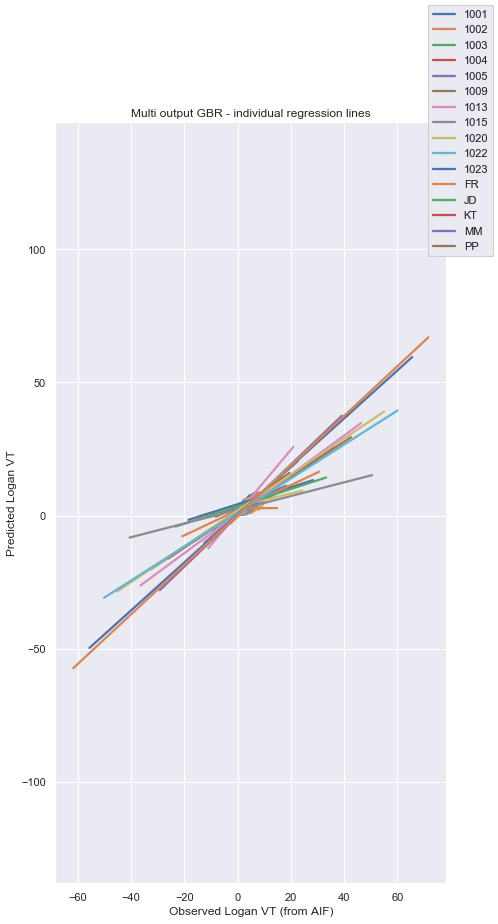

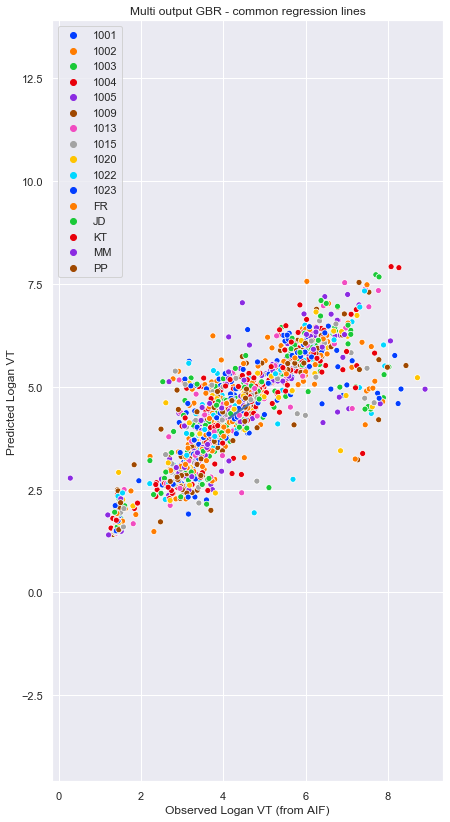

In [8]:
# GradientBoostingRegressor
y_true_base, y_pred_base = list(), list()
mae_errs_base = list()

cv = LeaveOneOut()

y_true, y_pred = list(), list()
mae_errs = list()

fig = plt.figure()
# set palette
palette = itertools.cycle(sns.color_palette())

for train_index, test_index in cv.split(X_noOutlier):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_noOutlier.iloc[train_index, :], X_noOutlier.iloc[test_index, :]
    y_train, y_test = y_noOutlier.iloc[train_index], y_noOutlier.iloc[test_index]

    gbr = GradientBoostingRegressor()
    model_gbr = MultiOutputRegressor(gbr)
    # Look at parameters used by our current forest
#     print('Parameters currently in use:\n')
#     pprint(model_gbr.estimator.get_params())
    # Base model evaluation: Fit the regressor with x and y data
    model_gbr.fit(X_train, y_train)  # use this if age, weight, and auc are scaled by a constant
    base_model_accuracy = evaluate(model_gbr, X_test.to_numpy(), y_test.to_numpy())
    
    yhat = model_gbr.predict(X_test)

    # store
    y_true_base.append(y_test.to_numpy())
    y_pred_base.append(yhat)

    print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
    mae_errs_base.append(mean_absolute_error(y_test, yhat))
    
    c = next(palette)
    # sns.regplot(x=y_test, y=yhat, scatter_kws={"color": "red"}, line_kws={"color": "black"})
#     sns.set(rc={"figure.figsize":(7, 7)})
    sns.regplot(x=np.array(y_test).reshape(-1), y=yhat.reshape(-1), color=c, ci=None)
    fig.legend(df['ATLaS_ID'].unique())
    plt.title('Multi output GBR - individual regression lines')
    plt.xlabel('Observed Logan VT (from AIF)')
    plt.ylabel('Predicted Logan VT')
    plt.axis('equal')
    plt.savefig("GBR-lineplot-old.png")

fig = plt.figure()
# sns.set(rc={"figure.figsize":(7, 7)})
sns.regplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), scatter=False)
sns.scatterplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
plt.title('Multi output GBR - common regression lines')
plt.xlabel('Observed Logan VT (from AIF)')
plt.ylabel('Predicted Logan VT')
plt.axis('equal')
plt.savefig("GBR-Scatter-old.png")
print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

print('debug')

In [167]:
df_truth.to_csv("ground_truth.csv")
df_preds.to_csv("gbr_preds.csv")

In [8]:
df_truth = pd.read_csv("ground_truth.csv", index_col=0)
df_preds = pd.read_csv("gbr_preds.csv", index_col=0)

In [12]:
# df_truth = pd.DataFrame(np.vstack(y_true_base))
# df_preds = pd.DataFrame(np.vstack(y_pred_base))
# df_truth.columns = y_test.columns
# df_preds.columns = y_test.columns
# std = np.std(np.vstack(y_true_base))
df_diff = df_preds - df_truth

In [36]:
df_diff.head()

,ctx-lh-bankssts-AIF,ctx-lh-caudalanteriorcingulate-AIF,ctx-lh-caudalmiddlefrontal-AIF,ctx-lh-cuneus-AIF,ctx-lh-entorhinal-AIF,ctx-lh-fusiform-AIF,ctx-lh-inferiorparietal-AIF,ctx-lh-inferiortemporal-AIF,ctx-lh-isthmuscingulate-AIF,ctx-lh-lateraloccipital-AIF,...,ctx-lh-insula-AIF,Left-Cerebellum-Cortex-AIF,Left-Thalamus-Proper-AIF,Left-Caudate-AIF,Left-Putamen-AIF,Left-Pallidum-AIF,Left-Hippocampus-AIF,Left-Amygdala-AIF,Left-Accumbens-area-AIF,Left-VentralDC-AIF
0,-0.19,0.11,0.23,-0.03,0.00,0.06,-0.02,0.01,-0.02,0.07,...,0.08,-0.02,0.07,-0.11,0.23,-0.08,-0.02,-0.07,0.08,0.10
1,0.38,0.29,0.12,0.59,0.20,0.14,0.39,-0.06,0.28,0.16,...,0.55,0.22,-0.08,0.17,0.21,0.40,-0.04,0.35,0.11,0.55
2,-0.21,-1.75,1.01,-0.54,-1.66,-2.92,-2.74,0.73,0.52,-2.36,...,-2.09,-2.47,-2.88,0.05,-0.94,-1.11,-1.48,-2.25,-1.08,-3.38
3,0.30,1.56,0.64,0.20,0.27,-0.01,-0.33,0.27,0.40,-0.30,...,0.40,0.27,0.25,-0.15,0.31,0.32,0.34,0.06,-0.04,0.54
4,-0.52,-1.04,-0.04,0.33,-0.35,0.13,0.20,-0.42,-0.36,0.32,...,1.13,-0.26,-0.24,1.80,0.47,0.52,-0.63,-0.15,0.15,-0.60


In [39]:
df_left = df_diff.iloc[:16]
df_rght = df_diff.iloc[16:]

In [40]:
th = 1.5
final_left = (df_left<-th).sum() + (df_left>th).sum()
final_rght = (df_rght<-th).sum() + (df_rght>th).sum()

In [46]:
final_left.to_csv("Indices0-15.csv")

In [45]:
final_rght.to_csv("Indices16-31.csv")

In [79]:
dfi = pd.read_csv(input_file, encoding='utf-8')

In [81]:
rdfi.columns

Index(['ATLaS_ID', 'Age', 'Sex', 'H&Y Stage', 'NET dose (mCi)', 'Weight (Kgs)',
       'AUC', 'Genotype', 'ctx-lh-bankssts-PBIF',
       'ctx-lh-caudalanteriorcingulate-PBIF',
       'ctx-lh-caudalmiddlefrontal-PBIF', 'ctx-lh-cuneus-PBIF',
       'ctx-lh-entorhinal-PBIF', 'ctx-lh-fusiform-PBIF',
       'ctx-lh-inferiorparietal-PBIF', 'ctx-lh-inferiortemporal-PBIF',
       'ctx-lh-isthmuscingulate-PBIF', 'ctx-lh-lateraloccipital-PBIF',
       'ctx-lh-lateralorbitofrontal-PBIF', 'ctx-lh-lingual-PBIF',
       'ctx-lh-medialorbitofrontal-PBIF', 'ctx-lh-middletemporal-PBIF',
       'ctx-lh-parahippocampal-PBIF', 'ctx-lh-paracentral-PBIF',
       'ctx-lh-parsopercularis-PBIF', 'ctx-lh-parsorbitalis-PBIF',
       'ctx-lh-parstriangularis-PBIF', 'ctx-lh-pericalcarine-PBIF',
       'ctx-lh-postcentral-PBIF', 'ctx-lh-posteriorcingulate-PBIF',
       'ctx-lh-precentral-PBIF', 'ctx-lh-precuneus-PBIF',
       'ctx-lh-rostralanteriorcingulate-PBIF',
       'ctx-lh-rostralmiddlefrontal-PBIF', 'ctx-lh

In [78]:
keysfinal_rght.keys()

Index(['ctx-lh-bankssts-AIF', 'ctx-lh-caudalanteriorcingulate-AIF',
       'ctx-lh-caudalmiddlefrontal-AIF', 'ctx-lh-cuneus-AIF',
       'ctx-lh-entorhinal-AIF', 'ctx-lh-fusiform-AIF',
       'ctx-lh-inferiorparietal-AIF', 'ctx-lh-inferiortemporal-AIF',
       'ctx-lh-isthmuscingulate-AIF', 'ctx-lh-lateraloccipital-AIF',
       'ctx-lh-lateralorbitofrontal-AIF', 'ctx-lh-lingual-AIF',
       'ctx-lh-medialorbitofrontal-AIF', 'ctx-lh-middletemporal-AIF',
       'ctx-lh-parahippocampal-AIF', 'ctx-lh-paracentral-AIF',
       'ctx-lh-parsopercularis-AIF', 'ctx-lh-parsorbitalis-AIF',
       'ctx-lh-parstriangularis-AIF', 'ctx-lh-pericalcarine-AIF',
       'ctx-lh-postcentral-AIF', 'ctx-lh-posteriorcingulate-AIF',
       'ctx-lh-precentral-AIF', 'ctx-lh-precuneus-AIF',
       'ctx-lh-rostralanteriorcingulate-AIF',
       'ctx-lh-rostralmiddlefrontal-AIF', 'ctx-lh-superiorfrontal-AIF',
       'ctx-lh-superiorparietal-AIF', 'ctx-lh-superiortemporal-AIF',
       'ctx-lh-supramarginal-AIF', 'ctx-

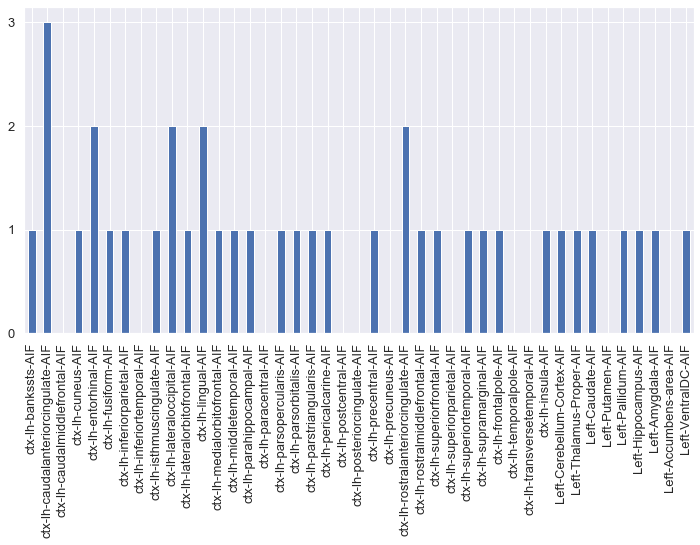

In [73]:
ax = final_left.plot.bar(figsize=(12, 6), fontsize=13, yticks=[0, 1, 2, 3])
plt.savefig("LH.png")

In [82]:
rkeys = final_rght.keys()

In [86]:
newkeys = [z.replace("-lh-", "-rh-").replace("Left-", "Right-") for z in rkeys]

In [115]:
rght = pd.Series(final_rght.values, newkeys)

In [116]:
rght

ctx-rh-bankssts-AIF                    0
ctx-rh-caudalanteriorcingulate-AIF     0
ctx-rh-caudalmiddlefrontal-AIF         1
ctx-rh-cuneus-AIF                      0
ctx-rh-entorhinal-AIF                  2
ctx-rh-fusiform-AIF                    2
ctx-rh-inferiorparietal-AIF            1
ctx-rh-inferiortemporal-AIF            1
ctx-rh-isthmuscingulate-AIF            3
ctx-rh-lateraloccipital-AIF            1
ctx-rh-lateralorbitofrontal-AIF        0
ctx-rh-lingual-AIF                     2
ctx-rh-medialorbitofrontal-AIF         2
ctx-rh-middletemporal-AIF              1
ctx-rh-parahippocampal-AIF             2
ctx-rh-paracentral-AIF                 2
ctx-rh-parsopercularis-AIF             1
ctx-rh-parsorbitalis-AIF               0
ctx-rh-parstriangularis-AIF            1
ctx-rh-pericalcarine-AIF               2
ctx-rh-postcentral-AIF                 1
ctx-rh-posteriorcingulate-AIF          2
ctx-rh-precentral-AIF                  3
ctx-rh-precuneus-AIF                   0
ctx-rh-rostralan

In [112]:
final_rght

ctx-lh-bankssts-AIF                    0
ctx-lh-caudalanteriorcingulate-AIF     0
ctx-lh-caudalmiddlefrontal-AIF         1
ctx-lh-cuneus-AIF                      0
ctx-lh-entorhinal-AIF                  2
ctx-lh-fusiform-AIF                    2
ctx-lh-inferiorparietal-AIF            1
ctx-lh-inferiortemporal-AIF            1
ctx-lh-isthmuscingulate-AIF            3
ctx-lh-lateraloccipital-AIF            1
ctx-lh-lateralorbitofrontal-AIF        0
ctx-lh-lingual-AIF                     2
ctx-lh-medialorbitofrontal-AIF         2
ctx-lh-middletemporal-AIF              1
ctx-lh-parahippocampal-AIF             2
ctx-lh-paracentral-AIF                 2
ctx-lh-parsopercularis-AIF             1
ctx-lh-parsorbitalis-AIF               0
ctx-lh-parstriangularis-AIF            1
ctx-lh-pericalcarine-AIF               2
ctx-lh-postcentral-AIF                 1
ctx-lh-posteriorcingulate-AIF          2
ctx-lh-precentral-AIF                  3
ctx-lh-precuneus-AIF                   0
ctx-lh-rostralan

In [2]:
final_rght.keys = newkeys

NameError: name 'newkeys' is not defined

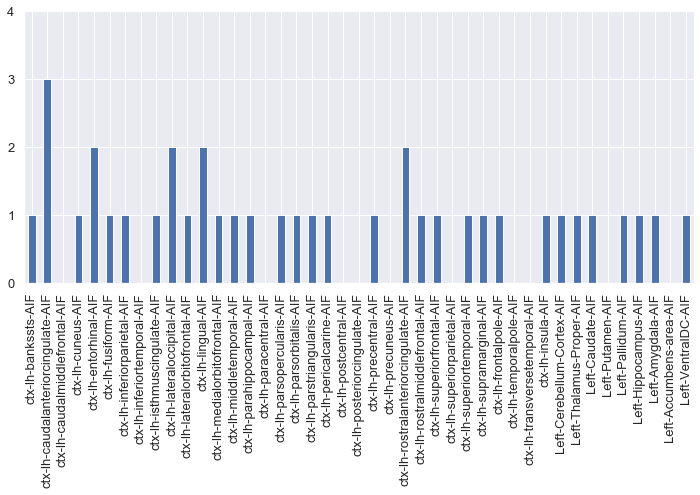

In [122]:
final_left.plot.bar(figsize=(12, 5), fontsize=13, yticks=[0, 1, 2, 3, 4])
plt.savefig("RH.png")

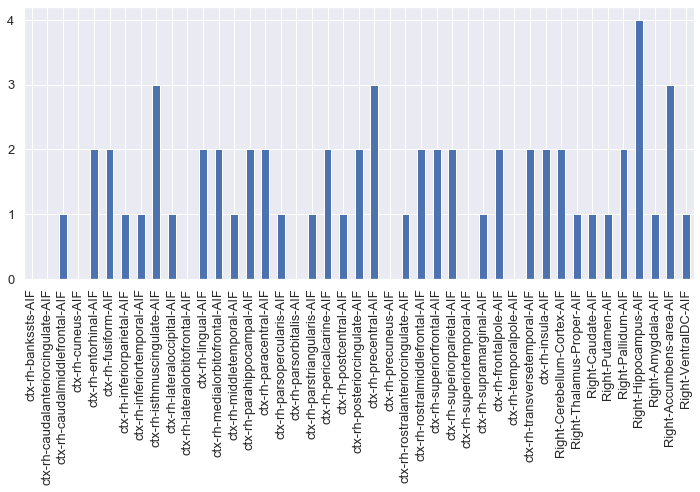

In [121]:
rght.plot.bar(figsize=(12, 5), fontsize=13, yticks=[0, 1, 2, 3, 4])
plt.savefig("RH.png")

In [95]:
final_rght.values

array([0, 0, 1, 0, 2, 2, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 2,
       3, 0, 1, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 1, 1, 1, 2, 4, 1, 3, 1])

In [111]:
truth=np.vstack(y_true_base).flatten()
predict=np.vstack(y_pred_base).flatten()

In [123]:
y_true_base

[array([[3.12520275, 1.87311611, 3.02648765, 3.06684422, 3.11708997,
         2.92361543, 2.97595827, 3.12283495, 2.60490322, 2.83949691,
         3.33581411, 2.8546362 , 3.16574573, 3.14098233, 2.49437375,
         2.90233624, 3.27782571, 3.26383011, 3.50502414, 3.03424849,
         3.13333947, 1.43462457, 3.01257389, 2.93665232, 3.02933749,
         3.30360394, 3.03834948, 2.91213316, 3.15079104, 3.0961491 ,
         3.15311846, 3.35099615, 3.16414039, 3.20905677, 2.58775481,
         3.67030561, 2.81289301, 3.18736929, 3.42219614, 2.85034328,
         3.2412597 , 3.10014902, 2.96644007]]),
 array([[4.17756649, 4.00172561, 4.79793407, 4.1643974 , 4.40492008,
         4.26598106, 4.12358251, 4.35105471, 3.67208245, 4.10937883,
         4.82267013, 4.08132579, 4.73099899, 4.35176843, 4.13634525,
         4.05495846, 4.77582978, 4.72921514, 4.98527259, 4.24721145,
         4.37953068, 4.01563392, 4.27402041, 4.12029406, 4.48153201,
         4.6875544 , 4.24468234, 4.02791572, 4.47026387

In [113]:
truth.shape

(1376,)

In [114]:
predict

array([2.93174708, 1.98171483, 3.25967038, ..., 5.6959593 , 6.3543742 ,
       5.57375422])

Pearson correlation R and p-val are:  0.39242 , 6.958756814991382e-52


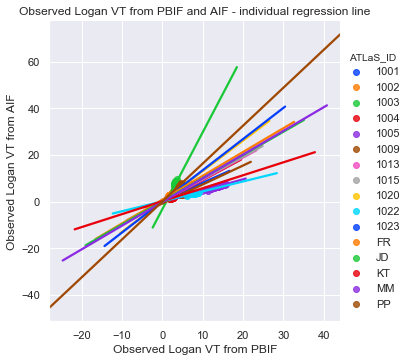

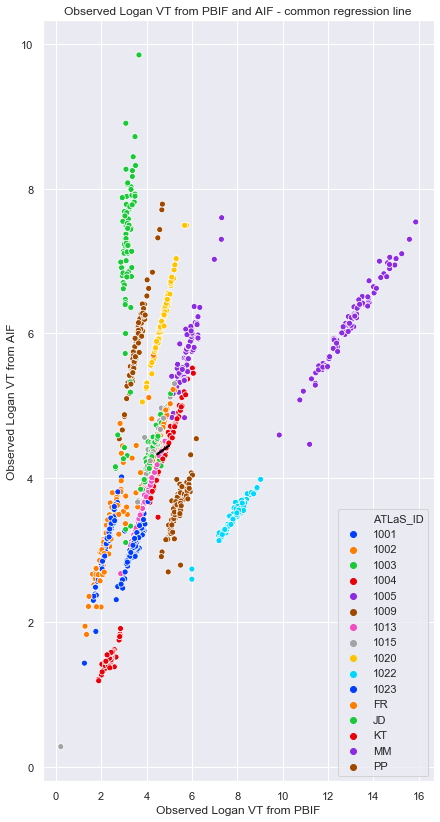

In [123]:
# plot original data
sns.lmplot(data=df_plot_long, x='VT_PBIF', y='VT_AIF', hue="ATLaS_ID", palette="bright", ci=None)
plt.title('Observed Logan VT from PBIF and AIF - individual regression line')
plt.xlabel('Observed Logan VT from PBIF')
plt.ylabel('Observed Logan VT from AIF')

fig = plt.figure()
sns.regplot(data=df_plot_long, x='VT_PBIF', y='VT_AIF', line_kws={"color": "black"}, scatter=False)
sns.scatterplot(data=df_plot_long, x="VT_PBIF", y="VT_AIF", hue="ATLaS_ID", palette="bright", legend="full")
plt.title('Observed Logan VT from PBIF and AIF - common regression line')
plt.xlabel('Observed Logan VT from PBIF')
plt.ylabel('Observed Logan VT from AIF')
plt.savefig("GBR-Scatter.png")
slope_o, intercept_o, r_value_o, p_value_o, std_err_o = stats.linregress(df_plot_long['VT_PBIF'], df_plot_long['VT_AIF'])
print('Pearson correlation R and p-val are: ', r_value_o.round(5), ',', p_value_o)

__TODO__

1. Find the outliers

2. If the prediction value for on ROI is far from the subj's mean value --> possible outlier

3. Smooth the signals first? 

4. Generate a single brain plot for all the subjects.

__TO SHOW__
1. Original Sneha Results
2. RF and GBR plots w/ statistical results
3. Brain image for outliers

In [91]:
np.mean(mae_errs_base)

0.5405199737381606

In [94]:
dr

,CV - Mean Absolute Error
RF,0.80
MLP,1.19
SVR,1.73
Ridge,1.51
GBR,0.54


In [79]:
# Ridge
y_true_base, y_pred_base = list(), list()
mae_errs_base = list()
for train_index, test_index in cv.split(X_noOutlier):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_noOutlier.iloc[train_index, :], X_noOutlier.iloc[test_index, :]
    y_train, y_test = y_noOutlier.iloc[train_index], y_noOutlier.iloc[test_index]

    ridge = Ridge()
    model_ridge = MultiOutputRegressor(ridge)

    # Look at parameters used by our current forest
#     print('Parameters currently in use:\n')
#     pprint(model_ridge.estimator.get_params())

    # Base model evaluation: Fit the regressor with x and y data
    model_ridge.fit(X_train, y_train)  # use this if age, weight, and auc are scaled by a constant
    base_model_accuracy = evaluate(model_ridge, X_test.to_numpy(), y_test.to_numpy())
    
    yhat = model_ridge.predict(X_test)

    # store
    y_true_base.append(y_test.to_numpy())
    y_pred_base.append(yhat)

    print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
    mae_errs_base.append(mean_absolute_error(y_test, yhat))

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [0]
Model Performance
Average Error: 0.5973 degrees.
Accuracy = 78.98%.
Mean Absolute Error of base model: 0.5972725515470095
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [1]
Model Performance
Average Error: 0.8268 degrees.
Accuracy = 81.11%.
Mean Absolute Error of base model: 0.8267941709614841
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [2]
Model Performance
Average Error: 3.2463 degrees.
Accuracy = 55.12%.
Mean Absolute Error of base model: 3.246314667618101
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [3]
Model Performance
Average Error: 0.2315 degrees.
Accuracy = 94.57%.
Mean Absolute Error of base model: 0.23150214261461505
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 1

In [80]:
np.mean(mae_errs_base)

1.5126799416196555

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [0]
Model Performance
Average Error: 0.8024 degrees.
Accuracy = 71.89%.
Mean Absolute Error of base model: 0.8024218090352515
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [1]
Model Performance
Average Error: 0.3889 degrees.
Accuracy = 91.10%.
Mean Absolute Error of base model: 0.38890382492354797
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [2]
Model Performance
Average Error: 2.3945 degrees.
Accuracy = 67.08%.
Mean Absolute Error of base model: 2.3945212689945206
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] TEST: [3]
Model Performance
Average Error: 0.3692 degrees.
Accuracy = 91.12%.
Mean Absolute Error of base model: 0.36918062428306625
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17

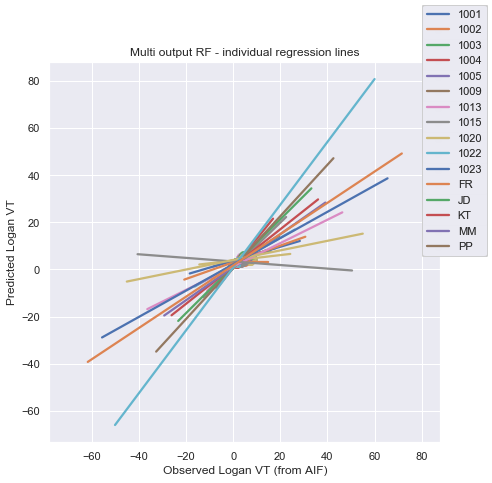

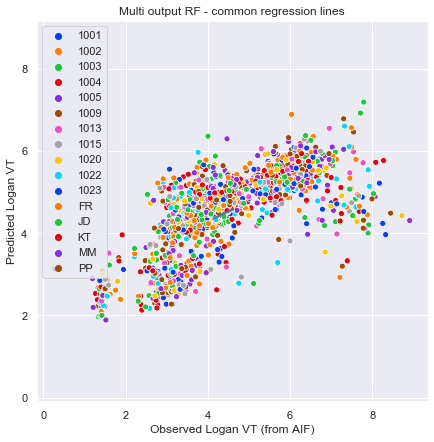

In [164]:
# Random Forest
y_true_base, y_pred_base = list(), list()
mae_errs_base = list()

cv = LeaveOneOut()

y_true, y_pred = list(), list()
mae_errs = list()

fig = plt.figure()
# set palette
palette = itertools.cycle(sns.color_palette())


for train_index, test_index in cv.split(X_noOutlier):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_noOutlier.iloc[train_index, :], X_noOutlier.iloc[test_index, :]
    y_train, y_test = y_noOutlier.iloc[train_index], y_noOutlier.iloc[test_index]

    ridge = RandomForestRegressor()
    model_ridge = MultiOutputRegressor(ridge)

    # Look at parameters used by our current forest
#     print('Parameters currently in use:\n')
#     pprint(model_ridge.estimator.get_params())

    # Base model evaluation: Fit the regressor with x and y data
    model_ridge.fit(X_train, y_train)  # use this if age, weight, and auc are scaled by a constant
    base_model_accuracy = evaluate(model_ridge, X_test.to_numpy(), y_test.to_numpy())
    
    yhat = model_ridge.predict(X_test)

    # store
    y_true_base.append(y_test.to_numpy())
    y_pred_base.append(yhat)

    print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
    mae_errs_base.append(mean_absolute_error(y_test, yhat))
    
    c = next(palette)
    # sns.regplot(x=y_test, y=yhat, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    sns.regplot(x=np.array(y_test).reshape(-1), y=yhat.reshape(-1), color=c, ci=None)
    fig.legend(df['ATLaS_ID'].unique())
    plt.title('Multi output RF - individual regression lines')
    plt.xlabel('Observed Logan VT (from AIF)')
    plt.ylabel('Predicted Logan VT')
    plt.axis('equal')
    plt.savefig("RF-lineplot.png")

fig = plt.figure()

sns.regplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), scatter=False)
sns.scatterplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
plt.title('Multi output RF - common regression lines')
plt.xlabel('Observed Logan VT (from AIF)')
plt.ylabel('Predicted Logan VT')
plt.axis('equal')
plt.savefig("RF-Scatter.png")
print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

print('debug')

In [108]:
np.mean(mae_errs_base)

0.8068190646170467

Pearson correlation R and p-val are:  0.71623 , 6.551491545377076e-217


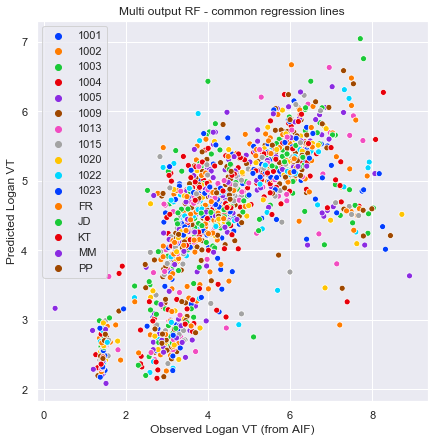

In [105]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=np.vstack(y_true_base).flatten(), y=np.vstack(y_pred_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
plt.title('Multi output RF - common regression lines')
plt.xlabel('Observed Logan VT (from AIF)')
plt.ylabel('Predicted Logan VT')
plt.savefig("RF-Scatter.png")
# plt.show()
print('Pearson correlation R and p-val are: ', r_value_p.round(5), ',', p_value_p)

### NN

In [56]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [63]:
y_true_base, y_pred_base = list(), list()
mae_errs_base = list()
for train_index, test_index in cv.split(X_noOutlier):

    X_train, X_test = X_noOutlier.iloc[train_index, :], X_noOutlier.iloc[test_index, :]
    y_train, y_test = y_noOutlier.iloc[train_index], y_noOutlier.iloc[test_index]
    
    regr = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(50, 15))
    
    regr.fit(X_train, y_train)  # use this if age, weight, and auc are scaled by a constant
    base_model_accuracy = evaluate(regr, X_test.to_numpy(), y_test.to_numpy())
    
    yhat = regr.predict(X_test)

    # store
    y_true_base.append(y_test.to_numpy())
    y_pred_base.append(yhat)

    print('Mean Absolute Error of base model:', mean_absolute_error(y_test, yhat))
    mae_errs_base.append(mean_absolute_error(y_test, yhat))

Model Performance
Average Error: 0.9027 degrees.
Accuracy = 67.77%.
Mean Absolute Error of base model: 0.9027196608962176
Model Performance
Average Error: 1.3919 degrees.
Accuracy = 68.08%.
Mean Absolute Error of base model: 1.3919366878145538
Model Performance
Average Error: 3.1810 degrees.
Accuracy = 56.45%.
Mean Absolute Error of base model: 3.181034355850325
Model Performance
Average Error: 0.2886 degrees.
Accuracy = 93.42%.
Mean Absolute Error of base model: 0.28860616039842885
Model Performance
Average Error: 1.4964 degrees.
Accuracy = 76.44%.
Mean Absolute Error of base model: 1.4964160368253232
Model Performance
Average Error: 1.0463 degrees.
Accuracy = 69.95%.
Mean Absolute Error of base model: 1.0462596222932061
Model Performance
Average Error: 1.5044 degrees.
Accuracy = 59.37%.
Mean Absolute Error of base model: 1.5044286415965533
Model Performance
Average Error: 0.4111 degrees.
Accuracy = 62.25%.
Mean Absolute Error of base model: 0.4110570600963813
Model Performance
Averag

In [64]:
np.mean(mae_errs_base)

1.188977379209999

In [92]:
d = {"RF":0.8037655032564262, 
     "MLP":1.188977379209999, 
     "SVR":1.7285567113975324, 
     "Ridge":1.5126799416196555, 
     "GBR":0.5405199737381606}
dr = pd.DataFrame(d, index=[0]).T
dr.columns = ["CV - Mean Absolute Error"]

In [166]:
dr.to_csv("cv-results.csv")

__Takeaway__: Tree-based models are more suitable for this task. GBR and RF are trained on MSE loss under default hyper parameters, but both reported rather good metrics on MAE w/ left-one Cross-Validation.

Ridge and SVR simply fail. MLP with minimal tuning doesn't work well for the small sample size.

__What to do next?__